In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [66]:
DATA_FOLDER = '/home/rafachem9/Documents/repos-git/python-for-data-science-and-machine-learning-bootcamp/kaggle/course-time-series/data'

retail_sales = pd.read_csv(
   f"{DATA_FOLDER}/us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month').to_period('D')

In [67]:
retail_sales.head()

,Clothing,Appliances,FoodAndBeverage,Automobiles,GeneralMerchandise,BuildingMaterials
Month,,,,,,
1992-01-01,6938,3657,29589,26788,14996,8964
1992-02-01,7524,3490,28570,28203,16015,9023
1992-03-01,8475,3669,29682,31684,17984,10608
1992-04-01,9401,3527,30228,32547,18872,11630
1992-05-01,9558,3571,31677,32883,20037,12327


In [68]:
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

In [70]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    f'{DATA_FOLDER}/train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)

/tmp/ipykernel_27258/1850285290.py:7: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


In [71]:
store_sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [72]:
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [73]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

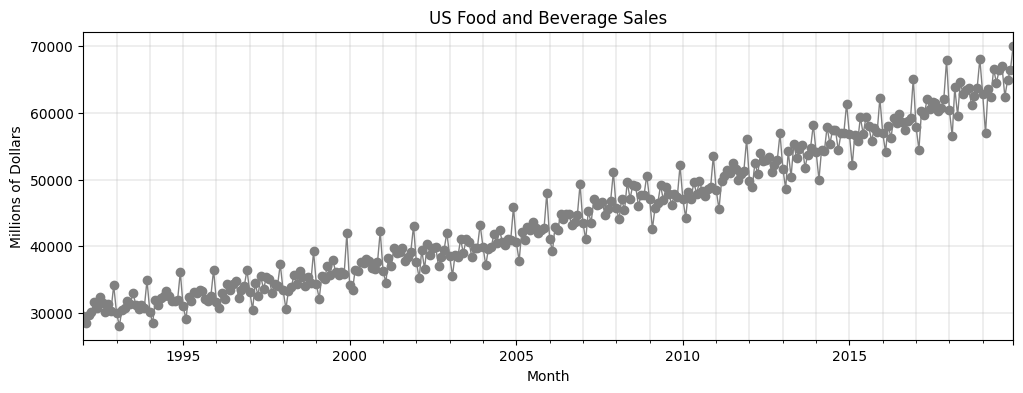

In [74]:
ax = food_sales.plot(figsize=(12, 4), marker='o', color='grey', linestyle='-', linewidth=1)
ax.grid(which='both', linestyle='-', linewidth=0.3, axis='both')  # Añadir una cuadrícula suave
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

In [75]:
#Now make a moving average plot to estimate the trend for this series.

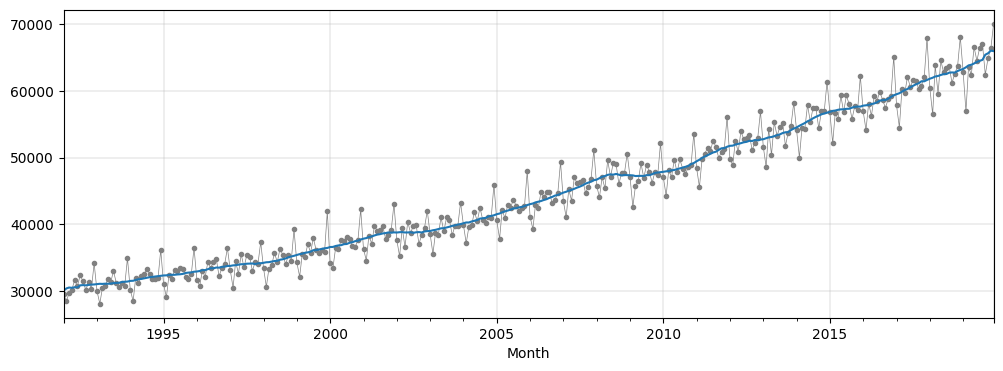

In [76]:
window_num = 12
moving_avg = food_sales.rolling(
    window=window_num,
    center=True,
    min_periods=int(window_num/2)
).mean()
ax = food_sales.plot(figsize=(12, 4), marker='o', markersize=3, color='grey', linestyle='-', linewidth=0.5)
moving_avg.plot(ax=ax)
ax.grid(True, which='major', linestyle='-', linewidth=0.3, axis='both')  # Añadir una cuadrícula suave


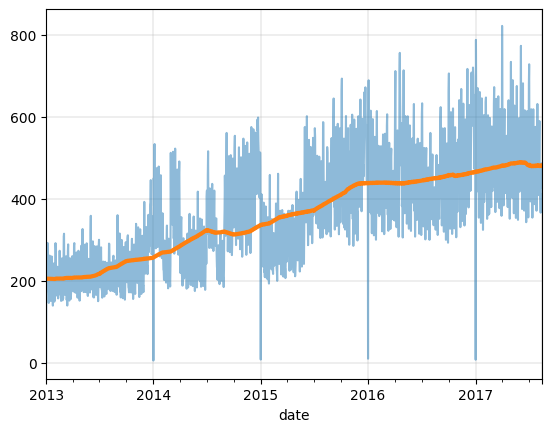

In [77]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(alpha=0.5)

ax = trend.plot(ax=ax, linewidth=3)
ax.grid(True, which='major', linestyle='-', linewidth=0.3, axis='both')  # Añadir una cuadrícula suave


# 3) Create a Trend Feature

Use `DeterministicProcess` to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

In [78]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target


In [79]:
dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

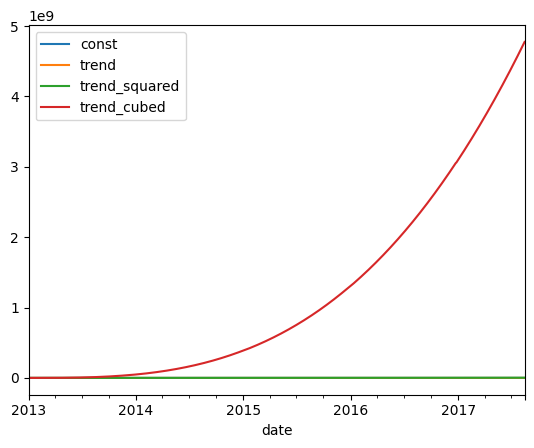

In [80]:
ax = X.plot()

<Axes: >

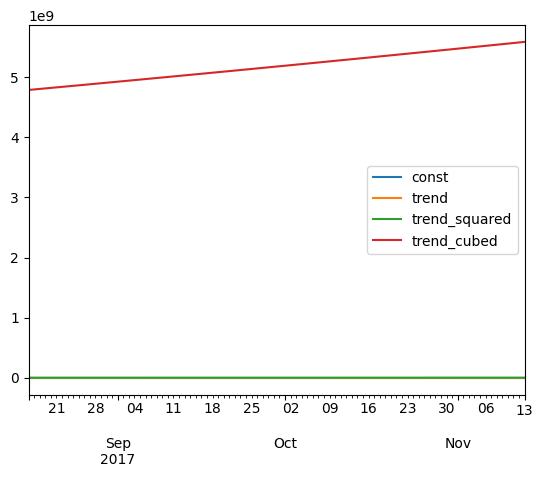

In [81]:
X_fore.plot()


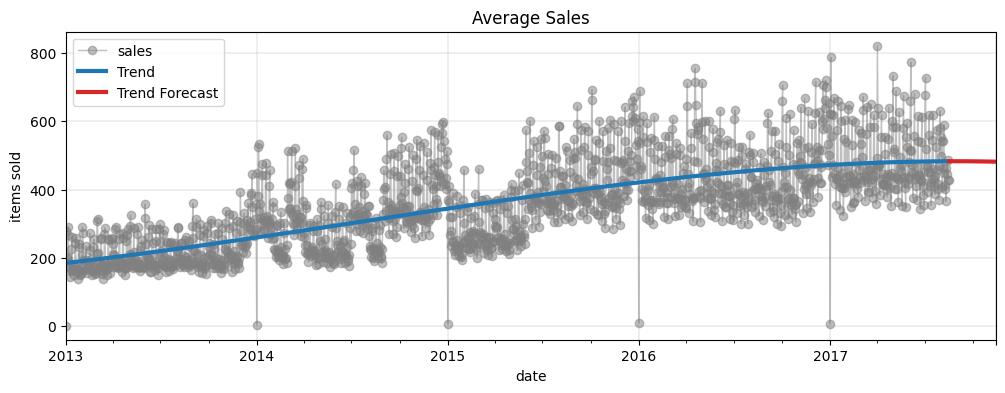

In [82]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(figsize=(12, 4), marker='o', color='grey', linestyle='-', linewidth=1, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()
ax.grid(True, which='major', linestyle='-', linewidth=0.3, axis='both')  # Añadir una cuadrícula suave


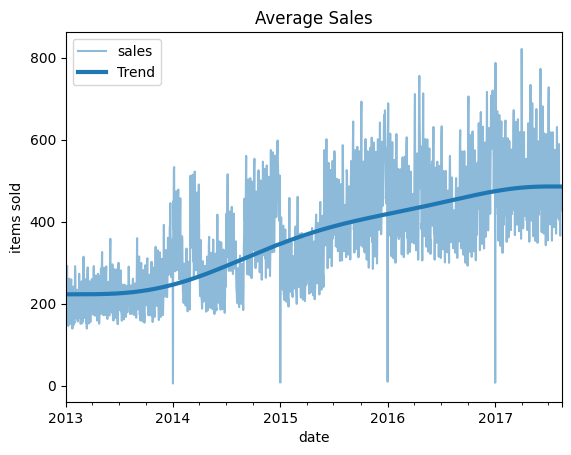

In [83]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=8)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

<Axes: xlabel='date'>

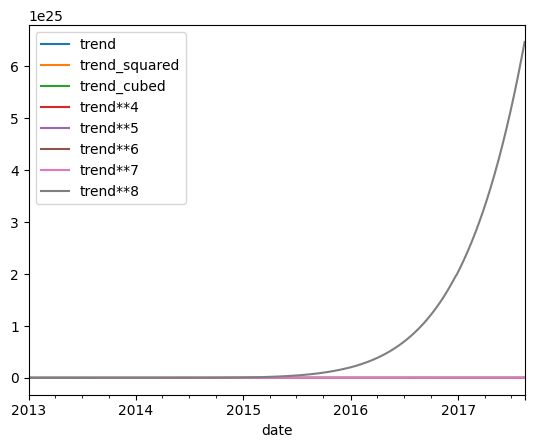

In [84]:
X.plot()

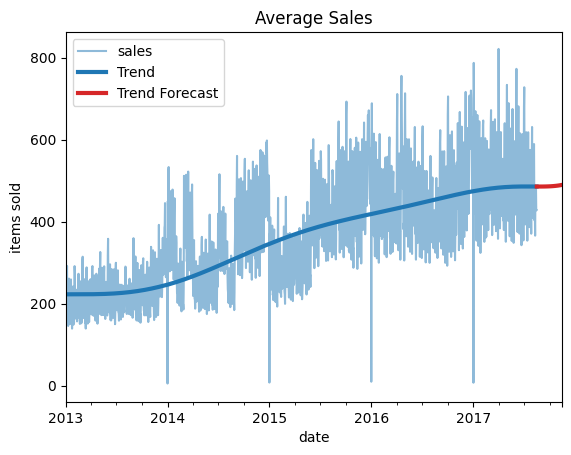

In [85]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();